# **Homework 3** Problem 2

## Prepare CIFAR-50 Dataset

Download dataset to your Google Drive from https://drive.google.com/drive/folders/1WGUKBP5Eta9DAltK1WtvRbX43iwP08DU?usp=sharing (please use your UW account to get access).

Unzip the files.

In [1]:
import json
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import torchvision.transforms as transforms
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip '/content/drive/MyDrive/UW/EEP596/HW3/cifar50.zip' -d '/content/data/cifar50/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/cifar50/images/sunflower/train_23323.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23431.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23457.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23464.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23507.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23533.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23624.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23707.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23713.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23801.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23814.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23830.jpg  
  inflating: /content/data/cifar50/images/sunflower/train_23874.jpg  
  inflating: /content/data/cifar50/imag

In [6]:
!unzip '/content/drive/MyDrive/UW/EEP596/HW3/cifar50_imbalance_0.02.zip' -d '/content/data/cifar50_imbalance_0.02/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4763.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4764.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4765.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4766.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4767.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4768.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4769.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4770.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4771.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4772.jpg  
  inflating: /content/data/cifar50_imbalance_0.02/images/flatfish/train_4773.jpg  
  inflating: /content/data/cifar50_i

Load and print label files to know the format of the provided labels.
- `cifar50_train.json`
- `cifar50_imbalance_0.02_train.json`

In [7]:
import json
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import torchvision.transforms as transforms
import os

Show some images with labels (class names) from dataset.

In [8]:
# TODO: visualize some data with labels./content/data
cifar50_json_file = '/content/data/cifar50/cifar50_train.json'
with open(cifar50_json_file) as f:
  imgs_anns = json.load(f)
items = imgs_anns['annotations']
print(imgs_anns['annotations'])

cifar50_imbalance_json_file = '/content/data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_train.json'
with open(cifar50_imbalance_json_file) as f:
  imgs_anns = json.load(f)
print(imgs_anns['annotations'])

record = {}

def relabel(items):
  hash_map = {}
  new_lable = 0
  for index,item in enumerate(items):
    labels = item["category_id"]
    if labels not in hash_map:
      hash_map[labels] = new_lable
      record[new_lable] = item["category"]
      new_lable += 1
  return hash_map


right_label = relabel(items)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
class Cifar50Set(Dataset):
    def __init__(self, root, dic, split, transform, reference_label = right_label):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.transform = transform
        # read json file 
        json_file = os.path.join(root,dic)
        json_file += '/'+dic+"_"+split+".json"
        with open(json_file) as f:
            self.imgs_anns = json.load(f)
        self.imgs_items = self.imgs_anns["annotations"]  
        self.imgs = [items["fpath"] for items in self.imgs_items]
        self.rightLabel = reference_label
        self.lbls = [int(self.rightLabel[items["category_id"]]) for items in self.imgs_items] 
    def __getitem__(self, index):
        # --------------------------------------------
        # 1. Read from file 
        # 2. Preprocess the data (torchvision.Transform)
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        # reading img
        img_path =  self.imgs[index]
        img_path = img_path.replace('\\','/')
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        lbl = self.lbls[index]
        return img, lbl

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.imgs)

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = Cifar50Set(root='./data/',dic = 'cifar50',split='train', transform=transform)
testset = Cifar50Set(root='./data/',dic = 'cifar50',split='test', transform=transform)
train_loader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=True)

In [11]:
def cifar_imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

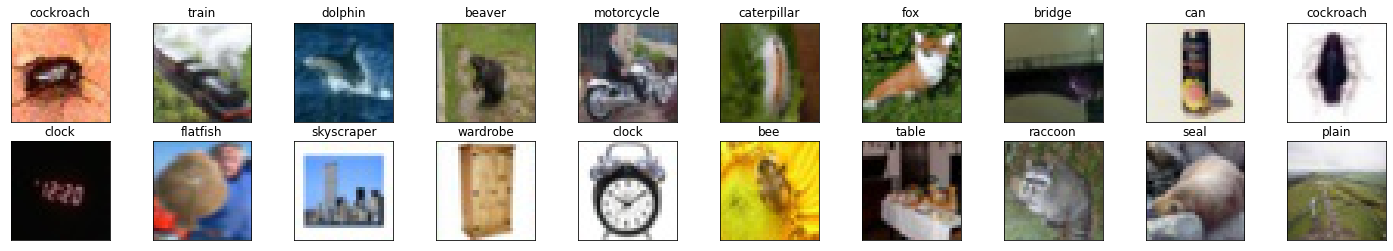

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
testlabels = labels.tolist()

fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks = [], yticks = [])
  plt.imshow(cifar_imshow(images[idx]))
  ax.set_title(record[testlabels[idx]])

## Train CNNs.

#### Use the CNN in HW2 to train the model on the balanced CIFAR50 dataset.

Train the CNN on the balanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set. 

Note: You can use any network configurations you implemented in HW2.

####Balanced

In [13]:
class CNN5(nn.Module):
  def __init__(self):
    super(CNN5, self).__init__()
    # TODO: define your CNN
    # 1 input image channel, 6 output channels, 3x3 square convolution
    # kernel
    #output_h =（originalSize_h+padding*2-kernelSize_h）/stride +1

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), padding = (1, 1))
    self.pool = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
    
    
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.dropout3 = nn.Dropout2d(p = 0.05)

    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm4 = nn.BatchNorm2d(256)
    self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
    
    
    # an affine operation: y = Wx + b
    self.dropoutfc = nn.Dropout(p = 0.1)
    self.fc1 = nn.Linear(4096, 1024)  
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 50)
    self.softmax1 = nn.Softmax(dim = 1)
    

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
   

    x = F.relu(self.conv3(x))
    x = self.batchnorm3(x)
    x = F.relu(self.conv3_1(x))
    x = self.pool(x)
    x = self.dropout3(x)

    x = F.relu(self.conv4(x))
    x = self.batchnorm4(x)
    x = F.relu(self.conv4_1(x))
    x = self.pool(x)
    
    
    x = x.view(-1, self.num_flat_features(x))
    x = self.dropoutfc(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropoutfc(x)
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn5 = CNN5().to(device)  # operate on GPU

In [14]:
# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn5.parameters(), lr=0.001)

In [15]:
n_epoch = 10

for epoch in range(n_epoch):  # loop over the dataset multiple times
  for i, (inputs, labels) in enumerate(train_loader, 0):
    # TODO: write training code
    inputs = inputs.to(device = device)
    labels = labels.to(device = device)

    optimizer.zero_grad()
    outputs = cnn5(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [16]:
# Check Accuracy
def check_accuracy(loader, model):

  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for input, label in loader:
      input = input.to(device = device)
      label = label.to(device = device)

      scores = model(input)
      #print(scores)
      #print(label)
      _, predictions = scores.max(1)
      #print(predictions)
      num_correct += (predictions == label).sum()
      num_samples += predictions.size(0)
      
    print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

  model.train()
  return 

In [17]:
print('-----Train data-----')
check_accuracy(train_loader, cnn5)
print('-----Test data-----')
check_accuracy(test_loader, cnn5)

-----Train data-----
Got 23229 / 25000 with accuracy 92.92
-----Test data-----
Got 2763 / 5000 with accuracy 55.26


#### Use the same CNN in HW2 to train the model on the imbalanced CIFAR50 dataset.

Train the CNN on the imbalanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set. 


In [18]:
class CNN6(nn.Module):
  def __init__(self):
    super(CNN6, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), padding = (1, 1))
    self.pool = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.dropout3 = nn.Dropout2d(p = 0.05)

    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm4 = nn.BatchNorm2d(256)
    self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
        
    # an affine operation: y = Wx + b
    self.dropoutfc = nn.Dropout(p = 0.1)
    self.fc1 = nn.Linear(4096, 1024)  
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 50)
    self.softmax1 = nn.Softmax(dim = 1)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
   
    x = F.relu(self.conv3(x))
    x = self.batchnorm3(x)
    x = F.relu(self.conv3_1(x))
    x = self.pool(x)
    x = self.dropout3(x)

    x = F.relu(self.conv4(x))
    x = self.batchnorm4(x)
    x = F.relu(self.conv4_1(x))
    x = self.pool(x)
        
    x = x.view(-1, self.num_flat_features(x))
    x = self.dropoutfc(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropoutfc(x)
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn6 = CNN6().to(device)  # operate on GPU

In [19]:
trainset = Cifar50Set(root='./data/',dic = 'cifar50_imbalance_0.02',split='train', transform=transform)
testset = Cifar50Set(root='./data/',dic = 'cifar50_imbalance_0.02',split='test', transform=transform)
train_loader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=True)

In [20]:
# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn6.parameters(), lr=0.001)

In [21]:
n_epoch = 10

for epoch in range(n_epoch):  # loop over the dataset multiple times
  for i, (inputs, labels) in enumerate(train_loader, 0):
    # TODO: write training code
    inputs = inputs.to(device = device)
    labels = labels.to(device = device)

    optimizer.zero_grad()
    outputs = cnn6(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [22]:
print('-----Train data-----')
check_accuracy(train_loader, cnn6)
print('-----Test data-----')
check_accuracy(test_loader, cnn6)

-----Train data-----
Got 5686 / 6430 with accuracy 88.43
-----Test data-----
Got 1658 / 5000 with accuracy 33.16


## Implement Tricks for LTR

Before starting this question, please read the paper for this homework: Bag of tricks for long-tailed visual recognition with deep convolutional neural networks.

According to this paper, select at least **three** tricks to implement on the imbalanced CIFAR50 training. 

####Trick 1

In [23]:
# TODO: trick 1 implementation
class CNN7(nn.Module):
  def __init__(self):
    super(CNN7, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), padding = (1, 1))
    self.pool = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.dropout3 = nn.Dropout2d(p = 0.05)

    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm4 = nn.BatchNorm2d(256)
    self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
        
    # an affine operation: y = Wx + b
    self.dropoutfc = nn.Dropout(p = 0.1)
    self.fc1 = nn.Linear(4096, 1024)  
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 50)
    self.softmax1 = nn.Softmax(dim = 1)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
   
    x = F.relu(self.conv3(x))
    x = self.batchnorm3(x)
    x = F.relu(self.conv3_1(x))
    x = self.pool(x)
    x = self.dropout3(x)

    x = F.relu(self.conv4(x))
    x = self.batchnorm4(x)
    x = F.relu(self.conv4_1(x))
    x = self.pool(x)
        
    x = x.view(-1, self.num_flat_features(x))
    x = self.dropoutfc(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropoutfc(x)
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn7 = CNN7().to(device)  # operate on GPU


In [24]:
trainset = Cifar50Set(root='./data/',dic = 'cifar50_imbalance_0.02',split='train', transform=transform)
testset = Cifar50Set(root='./data/',dic = 'cifar50_imbalance_0.02',split='test', transform=transform)

In [25]:
label_counter = np.zeros(50)

for _,label in trainset:
  label_counter[label]+=1

weight = 1./label_counter

samples_weight = np.array([weight[label] for label in trainset.lbls])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, replacement = True,num_samples = len(samples_weight))

classbalance_train_loader = DataLoader(dataset=trainset, batch_size=64,sampler=sampler, num_workers=4)

In [26]:
# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn7.parameters(), lr=0.001)

In [28]:
n_epoch = 10

for epoch in range(n_epoch):  # loop over the dataset multiple times
  count = 0
  for i, (inputs, labels) in enumerate(classbalance_train_loader, 0):
    # TODO: write training code
    inputs = inputs.to(device = device)
    labels = labels.to(device = device)

    optimizer.zero_grad()
    outputs = cnn7(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    count += len(labels)
print(count)

6430


In [29]:
print('-----Train data-----')
check_accuracy(classbalance_train_loader, cnn7)
print('-----Test data-----')
check_accuracy(test_loader, cnn7)

-----Train data-----
Got 5572 / 6430 with accuracy 86.66
-----Test data-----
Got 1362 / 5000 with accuracy 27.24


#### Trick 2

In [30]:
# TODO: trick 2 implementation
class CNN8(nn.Module):
  def __init__(self):
    super(CNN8, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), padding = (1, 1))
    self.pool = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.dropout3 = nn.Dropout2d(p = 0.05)

    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm4 = nn.BatchNorm2d(256)
    self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
        
    # an affine operation: y = Wx + b
    self.dropoutfc = nn.Dropout(p = 0.1)
    self.fc1 = nn.Linear(4096, 1024)  
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 50)
    self.softmax1 = nn.Softmax(dim = 1)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
   
    x = F.relu(self.conv3(x))
    x = self.batchnorm3(x)
    x = F.relu(self.conv3_1(x))
    x = self.pool(x)
    x = self.dropout3(x)

    x = F.relu(self.conv4(x))
    x = self.batchnorm4(x)
    x = F.relu(self.conv4_1(x))
    x = self.pool(x)
        
    x = x.view(-1, self.num_flat_features(x))
    x = self.dropoutfc(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropoutfc(x)
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn8 = CNN8().to(device)  # operate on GPU

In [31]:
trainset = Cifar50Set(root='./data/',dic = 'cifar50_imbalance_0.02',split='train', transform=transform)
testset = Cifar50Set(root='./data/',dic = 'cifar50_imbalance_0.02',split='test', transform=transform)

In [32]:
label_counter = np.zeros(50)

for _,label in trainset:
  label_counter[label]+=1

weight = 1./label_counter

samples_weight = np.array([weight[label] for label in trainset.lbls])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight, replacement = True,num_samples = len(samples_weight))


t2_train_loader = DataLoader(dataset=trainset, batch_size=64)
classbalance_train_loader = DataLoader(dataset=trainset, batch_size=64, sampler=sampler)

In [33]:
# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn8.parameters(), lr=0.001)

In [34]:
n_epoch = 10

for epoch in range(n_epoch):  # loop over the dataset multiple times
  for i, (inputs, labels) in enumerate(t2_train_loader, 0):
    # TODO: write training code
    inputs = inputs.to(device = device)
    labels = labels.to(device = device)
    optimizer.zero_grad()
    outputs = cnn8(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [35]:
n_epoch = 10

for epoch in range(n_epoch):  # loop over the dataset multiple times
  for i, (inputs, labels) in enumerate(classbalance_train_loader, 0):
    # TODO: write training code
    inputs = inputs.to(device = device)
    labels = labels.to(device = device)
    optimizer.zero_grad()
    outputs = cnn8(inputs)

    # Froze the conv layer.
    ct = 0
    for child in cnn8.children():
      ct += 1
      if ct < 7:
        for param in child.parameters():
          param.requires_grad = False

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [36]:
print('-----Train data-----')
check_accuracy(classbalance_train_loader, cnn8)
print('-----Test data-----')
check_accuracy(test_loader, cnn8)

-----Train data-----
Got 4747 / 6430 with accuracy 73.83
-----Test data-----
Got 792 / 5000 with accuracy 15.84


#### Trick 3

In [37]:
class Cifar50Set_Mix(Dataset):
    def __init__(self, root, dic, split, transform, reference_label = right_label):
        # --------------------------------------------
        # Initialize paths, transforms, and so on
        # --------------------------------------------
        self.transform = transform
        # read json file 
        json_file = os.path.join(root,dic)
        json_file += '/'+dic+"_"+split+".json"
        with open(json_file) as f:
            self.imgs_anns = json.load(f)
        self.imgs_items = self.imgs_anns["annotations"]  
        self.imgs = [items["fpath"] for items in self.imgs_items]
        self.rightLabel = reference_label
        self.lbls = [int(self.rightLabel[items["category_id"]]) for items in self.imgs_items] 
    def __getitem__(self, idx):
        # --------------------------------------------
        # 1. Read from file 
        # 2. Preprocess the data (torchvision.Transform)
        # 3. Return the data (e.g. image and label)
        # --------------------------------------------
        # reading img
        img_path =  self.imgs[idx]
        img_path = img_path.replace('\\','/')
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        lbl = self.lbls[idx]

        # Create a one hot label
        label = torch.zeros(50)
        label[self.lbls[idx]] = 1.


        # If data is for training, perform mixup, only perform mixup roughly on 1 for every 5 images
        if idx > 0 and idx%5 == 0:

            # Choose another image/label randomly
            mixup_idx = random.randint(0, len(img.numpy())-1)
            mixup_label = torch.zeros(10)
            label[self.lbls[mixup_idx]] = 1.
            if self.transform:
                mixup_image = transform(img.numpy()[mixup_idx])

            # Select a random number from the given beta distribution
            # Mixup the images accordingly
            alpha = 0.2
            lam = np.random.beta(alpha, alpha)
            img = lam * img + (1 - lam) * mixup_image
            label = lam * label + (1 - lam) * mixup_label

        return img, label

    def __len__(self):
        # --------------------------------------------
        # Indicate the total size of the dataset
        # --------------------------------------------
        return len(self.imgs)

In [38]:
def mixup(x, shuffle, lam, i, j):
    if shuffle is not None and lam is not None and i == j:
        x = lam * x + (1 - lam) * x[shuffle]
    return x

In [39]:
# TODO: trick 3 implementation
class CNN9(nn.Module):
  def __init__(self):
    super(CNN9, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), padding = (1, 1))
    self.pool = nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm3 = nn.BatchNorm2d(128)
    self.conv3_1 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (3, 3), padding = (1, 1))
    self.dropout3 = nn.Dropout2d(p = 0.05)

    self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
    self.batchnorm4 = nn.BatchNorm2d(256)
    self.conv4_1 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = (3, 3), padding = (1, 1))
        
    # an affine operation: y = Wx + b
    self.dropoutfc = nn.Dropout(p = 0.1)
    self.fc1 = nn.Linear(4096, 1024)  
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 50)
    self.softmax1 = nn.Softmax(dim = 1)
    
  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.batchnorm1(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
   
    x = F.relu(self.conv3(x))
    x = self.batchnorm3(x)
    x = F.relu(self.conv3_1(x))
    x = self.pool(x)
    x = self.dropout3(x)

    x = F.relu(self.conv4(x))
    x = self.batchnorm4(x)
    x = F.relu(self.conv4_1(x))
    x = self.pool(x)
        
    x = x.view(-1, self.num_flat_features(x))
    x = self.dropoutfc(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropoutfc(x)
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn9 = CNN9().to(device)  # operate on GPU

trainset = Cifar50Set_Mix(root='./data/',dic = 'cifar50_imbalance_0.02',split='train', transform=transform)
testset = Cifar50Set_Mix(root='./data/',dic = 'cifar50_imbalance_0.02',split='test', transform=transform)


t4_train_loader = DataLoader(dataset=trainset, batch_size=64)

In [40]:
# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn9.parameters(), lr=0.001)

In [41]:
n_epoch = 10

for epoch in range(n_epoch):  # loop over the dataset multiple times
  for i, (inputs, labels) in enumerate(t4_train_loader, 0):
    # TODO: write training code
    inputs = inputs.to(device = device)
    labels = labels.to(device = device)
    optimizer.zero_grad()
    outputs = cnn9(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

RuntimeError: ignored

In [42]:
print('-----Train data-----')
check_accuracy(t3_train_loader, cnn9)
print('-----Test data-----')
check_accuracy(test_loader, cnn9)

-----Train data-----


NameError: ignored

#### Evaluate and report the classification performance on CIFAR50 testing set.